# Analyze the existing pdf files that will be used for designs

This notebook was developed via ChatGPT Prompts. Components can be reused to analyze designs

**Areas of "back and forth" included:**
- Refining data layouts to get HChain/AgChain mappings
- Merging data for plotting
- Experimenting with plotting - vertical vs horizontal, first attempts at horizontal failed, but later worked
- "Finding" unaligned sequences - initial AGChain similarty plots indicated three "Unknown" study chains. None of the DFs showed unannotated data. But one study had Ag chains that were not a GFP or related protein. Thus, these sequences will not align. Finding those and combining the data with the aligned sequences, properly annotated the chains in the plots.

Along the way learned about and tested the Levenshtein library for comaparing sequences and getting "distances" as a fuction of the number of edits required to convert one sequence to another. Figuring out internal vs end differences prooved challening and an algoritm was generated, but did not work correctly as determined by inspecting the data. 

**Rabbit holes indluded:**
- printing data - print() vs ending a block with a variable like a dataframe.
  These display differently - print will break the data into block - new line rabbit hole
  whereas ending with my_df will show the dataframe as a table
- To show all rows, all col widths, etc:
    - Show all rows -- pd.set_option('display.max_rows', None)
    - Show all cols -- pd.set_option('display.max_columns', None)
    - No truncation -- pd.set_option('display.max_colwidth', None)
    - Expand to fit content -- pd.set_option('display.width', None)
    - Expand large dfs in jupyter -- pd.set_option('display.expand_frame_repr', False)
- To turn off the above settings
    - pd.reset_option('display.max_rows')
    - pd.reset_option('display.max_columns')
    - pd.reset_option('display.max_colwidth')
    - pd.reset_option('display.width')
    - pd.reset_option('display.expand_frame_repr')

## Prelims, libraries and initialization

In [ ]:
# get the libs - collect here so we know what we are using.
import re
from Bio.PDB import PDBParser, Polypeptide
from Bio.SeqUtils import seq1
from pathlib import Path
import pandas as pd

parser = PDBParser(QUIET=True)

## Set the pdb files path

In [4]:
from pathlib import Path

base_dir = Path("/Users/todd/Desktop/RFAntibody/fp_nanobodies")  # Replace with your root folder

pdb_files = []

for file in base_dir.rglob("*chothia.pdb"):
    # Check if the grandparent directory name is 4 chars (pdbId)
    # file.parent = 4-char dir, file.parent.parent = one of the 10 dirs
    if len(file.parent.name) == 4 and file.parent.parent.parent == base_dir:
        pdb_files.append(file)

print(f"Found {len(pdb_files)} *chothia.pdb files")


Found 23 *chothia.pdb files


## How many chains / file?

In [16]:
from collections import Counter

chain_counts = []

for pdb_file in sorted(pdb_files):
    # print(pdb_file.parent.parent.stem)
    structure = parser.get_structure(pdb_file.stem, pdb_file)
    chain_ids = set()
    for model in structure:
        for chain in model:
            chain_ids.add(chain.id)
        break  # first model only
    num_chains = len(chain_ids)
    classification = "single" if num_chains == 2 else "multi" if num_chains % 2 == 0 else "other"
    chain_counts.append({
        "Study" : pdb_file.parent.parent.stem,
        "PDB": pdb_file.name,
        "NumChains": num_chains,
        "Classification": classification,
        "Chains": ",".join(sorted(chain_ids))
    })

df_chains = pd.DataFrame(chain_counts)
df_chains.sort_values(by="NumChains").reset_index(drop=True)

,Study,PDB,NumChains,Classification,Chains
0,Affinity reagents,6lr7_chothia.pdb,2,single,"A,B"
1,Unique Mechanisms,8g0i_chothia.pdb,2,single,"A,D"
2,Rcomb prot purification,7sak_chothia.pdb,2,single,"A,B"
3,Rcomb prot purification,7sai_chothia.pdb,2,single,"A,C"
4,Rcomb prot purification,7sah_chothia.pdb,2,single,"A,B"
5,RFP-Cherry,6ir1_chothia.pdb,2,single,"A,B"
6,"PayWall - Structural Insights, 2 nanobodies, 1...",7e53_chothia.pdb,2,single,"A,B"
7,RFP-Cherry,6ir2_chothia.pdb,2,single,"A,B"
8,PayWall - Living cells,3g9a_chothia.pdb,2,single,"A,B"
9,Di-Gluebodies,8rle_chothia.pdb,3,other,"B,C,D"


## Build the Data Frame (DF)

In [6]:
# alternative layout noting the chain pairs

def parse_remark_5_roles(pdb_path):
    struct = {}
    hchains = set()
    agchains = set()
    with open(pdb_path) as f:
        for line in f:
            if line.startswith("REMARK   5 SINGLE HCHAIN="):
                match = re.search(r"HCHAIN=(\w)\s+AGCHAIN=(\w)", line)
                if match:
                    h, ag = match.group(1), match.group(2)
                    struct[h] = ag
                    hchains.add(h)
                    agchains.add(ag)
    return struct, hchains, agchains


def extract_chain_sequences_selective(pdb_path, agchains_wanted):
    structure = parser.get_structure(pdb_path.stem, pdb_path)
    chain_seqs = {}
    for model in structure:
        for chain in model:
            residues = []
            for res in chain:
                hetfield, resseq, icode = res.id
                is_hetatm = hetfield != " "
                is_ag = chain.id in agchains_wanted

                if is_hetatm and not is_ag:
                    continue  # skip HETATM for HChains

                try:
                    aa = seq1(res.get_resname(), custom_map={"MSE": "M", "SEP": "S", "TPO": "T", "PTR": "Y"})
                    residues.append(aa)
                except KeyError:
                    continue
            if residues:
                chain_seqs[chain.id] = "".join(residues)
        break  # only first model
    return chain_seqs


records = []

for pdb_file in pdb_files:
    struct, hchains, agchains = parse_remark_5_roles(pdb_file)
    chain_seqs = extract_chain_sequences_selective(pdb_file, agchains)

    for cid, seq in chain_seqs.items():
        role = "HChain" if cid in hchains else "AGChain" if cid in agchains else "Other"
        # Determine which chain this one pairs with, if any
        if role == "HChain":
            pairs_with = struct.get(cid, None)
        elif role == "AGChain":
            # reverse lookup for AGChain
            pairs_with = [h for h, ag in struct.items() if ag == cid]
            pairs_with = ",".join(pairs_with) if pairs_with else None
        else:
            pairs_with = None

        records.append({
            "Study" : pdb_file.parent.parent.stem,
            "PDB": pdb_file.name,
            "Structure": struct,
            "Chain": cid,
            "PairsWith": pairs_with,
            "Role": role,
            "Length": len(seq),
            "Sequence": seq,
        })

df = pd.DataFrame(records)
df

,Study,PDB,Structure,Chain,PairsWith,Role,Length,Sequence
0,"PayWall - Structural Insights, 2 nanobodies, 1...",7e53_chothia.pdb,{'B': 'A'},A,B,AGChain,284,SKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLKFI...
1,"PayWall - Structural Insights, 2 nanobodies, 1...",7e53_chothia.pdb,{'B': 'A'},B,A,HChain,126,QVQLQESGGGSVQAGGSLRLSCAASGPTYSSYFMAWFRQAPGMERE...
2,Substrate-engaged,6itc_chothia.pdb,"{'V': 'Y', 'C': 'G'}",A,None,Other,765,RTLNRYEKIANDIDAIRGDYENLSDDALKHKTIEFKERLEKGATTD...
3,Substrate-engaged,6itc_chothia.pdb,"{'V': 'Y', 'C': 'G'}",Y,V,AGChain,422,FRTISNFMRVSDIRNKIIFTLLMLIVFRIGTFIPVPSVNTDVLKLQ...
4,Substrate-engaged,6itc_chothia.pdb,"{'V': 'Y', 'C': 'G'}",E,None,Other,58,QRVTNFFKEVVRELKKVSWPNRKELVNYTAVVLATVAFFTVFFAVI...
...,...,...,...,...,...,...,...,...
86,Thermodynamic analysis,3ogo_chothia.pdb,"{'E': 'A', 'F': 'C', 'G': 'B', 'H': 'B'}",F,C,HChain,115,QVQLVESGGALVQPGGSLRLSCAASGFPVNRYSMRWYRQAPGKERE...
87,Thermodynamic analysis,3ogo_chothia.pdb,"{'E': 'A', 'F': 'C', 'G': 'B', 'H': 'B'}",G,B,HChain,116,QVQLVESGGALVQPGGSLRLSCAASGFPVNRYSMRWYRQAPGKERE...
88,Thermodynamic analysis,3ogo_chothia.pdb,"{'E': 'A', 'F': 'C', 'G': 'B', 'H': 'B'}",H,B,HChain,116,QVQLVESGGALVQPGGSLRLSCAASGFPVNRYSMRWYRQAPGKERE...
89,Affinity reagents,6lr7_chothia.pdb,{'B': 'A'},A,B,AGChain,364,GEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICT...


## Chain Identity

In [7]:
# Make a clean column without 'X'
df['Sequence_noX'] = df['Sequence'].str.replace('X', '', regex=False)

# Drop if already present to avoid conflict
if 'Sequence_Count' in df.columns:
    df = df.drop(columns=['Sequence_Count'])

# Group by Sequence, Role, and Length and count
grouped = df.groupby(['Sequence', 'Role', 'Length']).size().reset_index(name='Sequence_Count')

# Merge safely
df = df.merge(grouped, on=['Sequence', 'Role', 'Length'], how='left')

# Group by cleaned sequence (noX)
grouped_noX = df.groupby('Sequence_noX', as_index=False).agg({
    'Study' : lambda x: ', '.join(sorted(set(x))),
    'PDB': lambda x: ', '.join(sorted(set(x))),
    'Role': 'first',
    'Length': 'first',
    'Sequence_Count': 'first'
})

# Sort
grouped_noX_sorted = grouped_noX.sort_values(by='Sequence_Count', ascending=False)

# Display options
pd.reset_option('display.max_colwidth')
pd.reset_option('display.width')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Show result
print("\nGrouped by sequence without 'X':")
grouped_noX_sorted.reset_index(drop=True)



Grouped by sequence without 'X':


,Sequence_noX,Study,PDB,Role,Length,Sequence_Count
0,VQLVESGGGLVQAGGSLRLSCATSGFTFSDYAMGWFRQAPGKEREF...,"RFP-Cherry, Rcomb prot purification","6ir2_chothia.pdb, 7saj_chothia.pdb",HChain,124,6
1,QVQLVENGGACVKPGGSLRLSCAASGFPVNRYSMRWYRQAPGKERE...,Di-Gluebodies,"8rl9_chothia.pdb, 8rlb_chothia.pdb, 8rle_choth...",HChain,114,3
2,QVQLVESGGALVQPGGSLRLSCAASGFPVNRYSMRWYRQAPGKERE...,"PayWall - Living cells, Thermodynamic analysis","3k1k_chothia.pdb, 3ogo_chothia.pdb",HChain,115,3
3,QLVENGGGCVKAGGSLRLSCAASQGTLSNLVTGWFRRAPGKEREFV...,Di-Gluebodies,"8rlc_chothia.pdb, 8rle_chothia.pdb",HChain,116,2
4,QVQLVESGGGLVQAGGSLRLSCAASGFPVDTQWMHWYRQAPGKERE...,Improved Protein Tag,7cz0_chothia.pdb,HChain,116,2
5,NMAIIKEFMRFKVHMEGSVNGHEFEIEGEGEGRPYEGTQTAKLKVT...,Rcomb prot purification,7sal_chothia.pdb,Other,217,2
6,QVQLVESGGGLVQAGGSLRLSCAASGPTGAMAWFRQAPGMEREFVG...,Unique Mechanisms,8sfx_chothia.pdb,HChain,119,2
7,QVQLVESGGGLVQAGGSLRLSCVASGSAPSFFAMAWYRQSPGNERE...,Rcomb prot purification,7sal_chothia.pdb,HChain,121,2
8,QVQLVESGGRLVQAGDSLRLSCAASGRTFSTSAMAWFRQAPGRERE...,"Rcomb prot purification, Unique Mechanisms","7sah_chothia.pdb, 8sfs_chothia.pdb",HChain,126,2
9,QVQLVENGGGCVKAGGSLRLSCAASGSIFSINRMTWYRQAPGKERE...,Di-Gluebodies,"8rl9_chothia.pdb, 8rlb_chothia.pdb",HChain,124,2


## Alignment chain similarity

In [8]:
from Bio.Align import PairwiseAligner

# Example input DataFrame (replace with your actual df)
# df = pd.read_csv('your_data.csv')
# df should have 'Sequence_noX', 'PDB', 'Role', 'Length'

# Initialize aligner
aligner = PairwiseAligner()
aligner.mode = 'global'
aligner.match_score = 1
aligner.mismatch_score = 0
aligner.open_gap_score = -1
aligner.extend_gap_score = -0.5

# Unique sequences list
sequences = df['Sequence_noX'].tolist()
similar_pairs = []
threshold_identity = 30.0  # Identity % threshold

# Iterate over all pairs
for i, seq1 in enumerate(sequences):
    for j in range(i + 1, len(sequences)):
        seq2 = sequences[j]

        # Perform alignment
        alignment = next(aligner.align(seq1, seq2))
        
        # Reconstruct aligned sequences with gaps
        aligned_seq1 = []
        aligned_seq2 = []
        pos1, pos2 = 0, 0

        for (start1, end1), (start2, end2) in zip(alignment.aligned[0], alignment.aligned[1]):
            # Gaps in seq1
            while pos1 < start1:
                aligned_seq1.append(seq1[pos1])
                aligned_seq2.append('-')
                pos1 += 1
            # Gaps in seq2
            while pos2 < start2:
                aligned_seq1.append('-')
                aligned_seq2.append(seq2[pos2])
                pos2 += 1
            # Matching region
            while start1 < end1:
                aligned_seq1.append(seq1[start1])
                aligned_seq2.append(seq2[start2])
                start1 += 1
                start2 += 1
                pos1 += 1
                pos2 += 1
        # Remaining tails
        while pos1 < len(seq1):
            aligned_seq1.append(seq1[pos1])
            aligned_seq2.append('-')
            pos1 += 1
        while pos2 < len(seq2):
            aligned_seq1.append('-')
            aligned_seq2.append(seq2[pos2])
            pos2 += 1

        # Convert to string
        aligned_seq1 = ''.join(aligned_seq1)
        aligned_seq2 = ''.join(aligned_seq2)

        # Alignment statistics
        alignment_length = len(aligned_seq1)
        match_count = sum(1 for a, b in zip(aligned_seq1, aligned_seq2) if a == b)
        identity = round((match_count / alignment_length) * 100, 2)

        # Mismatch positions summary
        mismatch_positions = []
        for idx, (a, b) in enumerate(zip(aligned_seq1, aligned_seq2)):
            if a != b:
                mismatch_positions.append(f"{idx + 1}:{a}/{b}")
        mismatch_summary = "; ".join(mismatch_positions)

        # If above threshold, record the pair
        if identity >= threshold_identity:
            similar_pairs.append((seq1, seq2, identity, alignment_length, match_count, mismatch_summary))

# Create DataFrame of results
similar_df = pd.DataFrame(similar_pairs, columns=['Seq1', 'Seq2', 'Identity', 'Alignment_Length', 'Match_Count', 'Mismatch_Positions'])

# Metadata merge
meta_df = df[['Sequence_noX', 'PDB', 'Role', 'Length', 'Study']].drop_duplicates()

# Merge metadata for Seq1
similar_df = similar_df.merge(meta_df, left_on='Seq1', right_on='Sequence_noX', how='left') \
                       .rename(columns={'PDB': 'PDB_Seq1', 'Study': 'Study_Seq1', 'Role': 'Role_Seq1', 'Length': 'Length_Seq1'}) \
                       .drop(columns=['Sequence_noX'])

# Merge metadata for Seq2
similar_df = similar_df.merge(meta_df, left_on='Seq2', right_on='Sequence_noX', how='left') \
                       .rename(columns={'PDB': 'PDB_Seq2', 'Study': 'Study_Seq2', 'Role': 'Role_Seq2', 'Length': 'Length_Seq2'}) \
                       .drop(columns=['Sequence_noX'])


# Flag same PDB
similar_df['Same_PDB'] = similar_df['PDB_Seq1'] == similar_df['PDB_Seq2']

# Display all rows without truncation
pd.set_option('display.max_rows', None)
pd.reset_option('display.max_colwidth')

# Sort by Same_PDB, PDB_Seq1, Role_Seq1, Identity
similar_df = similar_df.sort_values(by=['Identity', 'Same_PDB', 'PDB_Seq1', 'Role_Seq1'], ascending=[False, True, True, False]).reset_index(drop=True)

print(similar_df.shape)

similar_df.head()

(3621, 15)


,Seq1,Seq2,Identity,Alignment_Length,Match_Count,Mismatch_Positions,PDB_Seq1,Role_Seq1,Length_Seq1,Study_Seq1,PDB_Seq2,Role_Seq2,Length_Seq2,Study_Seq2,Same_PDB
0,QVQLVESGGALVQPGGSLRLSCAASGFPVNRYSMRWYRQAPGKERE...,QVQLVESGGALVQPGGSLRLSCAASGFPVNRYSMRWYRQAPGKERE...,100.0,115,115,,3k1k_chothia.pdb,HChain,115,PayWall - Living cells,3ogo_chothia.pdb,HChain,115,Thermodynamic analysis,False
1,QVQLVESGGALVQPGGSLRLSCAASGFPVNRYSMRWYRQAPGKERE...,QVQLVESGGALVQPGGSLRLSCAASGFPVNRYSMRWYRQAPGKERE...,100.0,115,115,,3k1k_chothia.pdb,HChain,115,PayWall - Living cells,3ogo_chothia.pdb,HChain,115,Thermodynamic analysis,False
2,QVQLVESGGALVQPGGSLRLSCAASGFPVNRYSMRWYRQAPGKERE...,QVQLVESGGALVQPGGSLRLSCAASGFPVNRYSMRWYRQAPGKERE...,100.0,115,115,,3k1k_chothia.pdb,HChain,115,PayWall - Living cells,3ogo_chothia.pdb,HChain,115,Thermodynamic analysis,False
3,KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIC...,KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIC...,100.0,224,224,,3k1k_chothia.pdb,AGChain,377,PayWall - Living cells,6itc_chothia.pdb,AGChain,225,Substrate-engaged,False
4,KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIC...,KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIC...,100.0,224,224,,3k1k_chothia.pdb,AGChain,319,PayWall - Living cells,6itc_chothia.pdb,AGChain,225,Substrate-engaged,False


In [9]:
# Combine the sequences that did not align into similar_df

# All unique sequences from original DataFrame
all_seqs = set(df['Sequence_noX'].tolist())

# Sequences that appeared in similar pairs (Seq1 or Seq2)
aligned_seqs = set(similar_df['Seq1']).union(set(similar_df['Seq2']))

# Sequences that did not align above threshold
unaligned_seqs = all_seqs - aligned_seqs

# debug
print(f"Number of sequences that did not align above threshold: {len(unaligned_seqs)}")
print("Unaligned sequences:")
for seq in unaligned_seqs:
    pdb = df[df['Sequence_noX'] == seq]['PDB'].iloc[0]
    print(f"{pdb} → {seq}")

# Create entries for unaligned sequences as self-pairs
unaligned_rows = []
for seq in unaligned_seqs:
    pdb = df[df['Sequence_noX'] == seq]['PDB'].iloc[0]
    role = df[df['Sequence_noX'] == seq]['Role'].iloc[0]
    study = df[df['Sequence_noX'] == seq]['Study'].iloc[0]
    length = df[df['Sequence_noX'] == seq]['Length'].iloc[0]
    
    unaligned_rows.append({
        'Seq1': seq,
        'Seq2': seq,
        'Identity': 100.0,
        'Alignment_Length': length,
        'Match_Count': length,
        'Mismatch_Positions': '',
        'PDB_Seq1': pdb,
        'Study_Seq1': study,
        'Role_Seq1': role,
        'Length_Seq1': length,
        'PDB_Seq2': pdb,
        'Study_Seq2': study,
        'Role_Seq2': role,
        'Length_Seq2': length,
        'Same_PDB': True
    })

# Convert to DataFrame
unaligned_df = pd.DataFrame(unaligned_rows)

# Combine with similar_df
combined_df = pd.concat([similar_df, unaligned_df], ignore_index=True)

# Sort again if needed
combined_df = combined_df.sort_values(by=['Identity', 'Same_PDB', 'PDB_Seq1', 'Role_Seq1'], 
                                      ascending=[False, True, True, False]).reset_index(drop=True)

# Done!
print(f"\nCombined DataFrame shape: {combined_df.shape}")


Number of sequences that did not align above threshold: 6
Unaligned sequences:
6itc_chothia.pdb → QRVTNFFKEVVRELKKVSWPNRKELVNYTAVVLATVAFFTVFFAVIDLGISQLIRLVF
6itc_chothia.pdb → AKKTAIAIAVALAGFATVASYAQYEDGCSGELERDSPHSYHSG
8rlc_chothia.pdb → GRGAAAAILSLGNVLNYLDRYTVAGVLLDIQQHFGVKDRGAGLLQSVFICSFMVAAPIFGYLGDRFNRKVILSCGIFFWSAVTFSSSFIPQQYFWLLVLSRGLVGIGEASYSTIAPTIIGDLFTKNTRTLMLSVFYFAIPLGSGLGYITGSSVKQAAGDWHWALRVSPVLGMITGTLILILVPATKARTSWLRDMKALIRNRSYVFSSLATSAVSFATGALGMWIPLYLHRAQVVQKTAEGAKDSLIFGAITCFTGFLGVVTGAGATRWCRLKTQRADPLVCAVGMLGSAIFICLIFVAAKSSIVGAYICIFVGETLLFSNWAITADILMYVVIPTRRATAVALQSFTSHLLGDAGSPYLIGFISDLIRQSTKDSPLWEFLSLGYALMLCPFVVVLGGMFFLATALFFVSDRARAEQQVNQ
6itc_chothia.pdb → FRTISNFMRVSDIRNKIIFTLLMLIVFRIGTFIPVPSVNTDVLKLQDQLNAFGVLNIFCGGALQNFSIFAMGVMPYITASIIVQLLQMDVVPKFAEWSKQGEMGRRKLAQFTRYFTIVLGFIQALGMSYGFNNLAGGMLIQNPGIGTYLLIAVVLTAGTAFLMWLGEQITAKGVGNGISIIIFAGIVSGIPTILNQIYAQTLNIVRLLLVALAVVAVIVGVIYIQQAFRKIPIQYAKRLEGRNPVGGHSTHLPLKVNPAGVIPVIFAVSFLIAPPTIASFFGTNDVTLWIRRTFDYTHPVGMTIYVVLIIAFTYFYAFVQ

## Plots

### Horizontal

In [10]:
import matplotlib.colors as mcolors
import pandas as pd

# Create a DataFrame mapping sequence → Study, PDB (drop duplicates)
seq_study_pdb_df = pd.concat([
    combined_df[['Seq1', 'Study_Seq1', 'PDB_Seq1']].rename(columns={'Seq1': 'Seq', 'Study_Seq1': 'Study', 'PDB_Seq1': 'PDB'}),
    combined_df[['Seq2', 'Study_Seq2', 'PDB_Seq2']].rename(columns={'Seq2': 'Seq', 'Study_Seq2': 'Study', 'PDB_Seq2': 'PDB'})
]).set_index('Seq')


# Fill missing values or drop if needed
seq_study_pdb_df['Study'] = seq_study_pdb_df['Study'].fillna('UnknownStudy')
seq_study_pdb_df['PDB'] = seq_study_pdb_df['PDB'].fillna('UnknownPDB')

# Convert to dict: seq → (PDB, Study)
seq_to_info = seq_study_pdb_df.apply(lambda row: (row['PDB'], row['Study']), axis=1).to_dict()

# Unique studies & colors for legend
unique_studies = sorted(set(seq_study_pdb_df['Study']))
color_palette = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())

# Map Study to color
study_to_color = {study: color_palette[i % len(color_palette)] for i, study in enumerate(unique_studies)}
study_to_color

{'Affinity reagents': '#1f77b4',
 'Di-Gluebodies': '#ff7f0e',
 'Improved Protein Tag': '#2ca02c',
 'PayWall - Living cells': '#d62728',
 'PayWall - Structural Insights, 2 nanobodies, 1 epitope': '#9467bd',
 'RFP-Cherry': '#8c564b',
 'Rcomb prot purification': '#e377c2',
 'Substrate-engaged': '#7f7f7f',
 'Thermodynamic analysis': '#bcbd22',
 'Unique Mechanisms': '#17becf'}

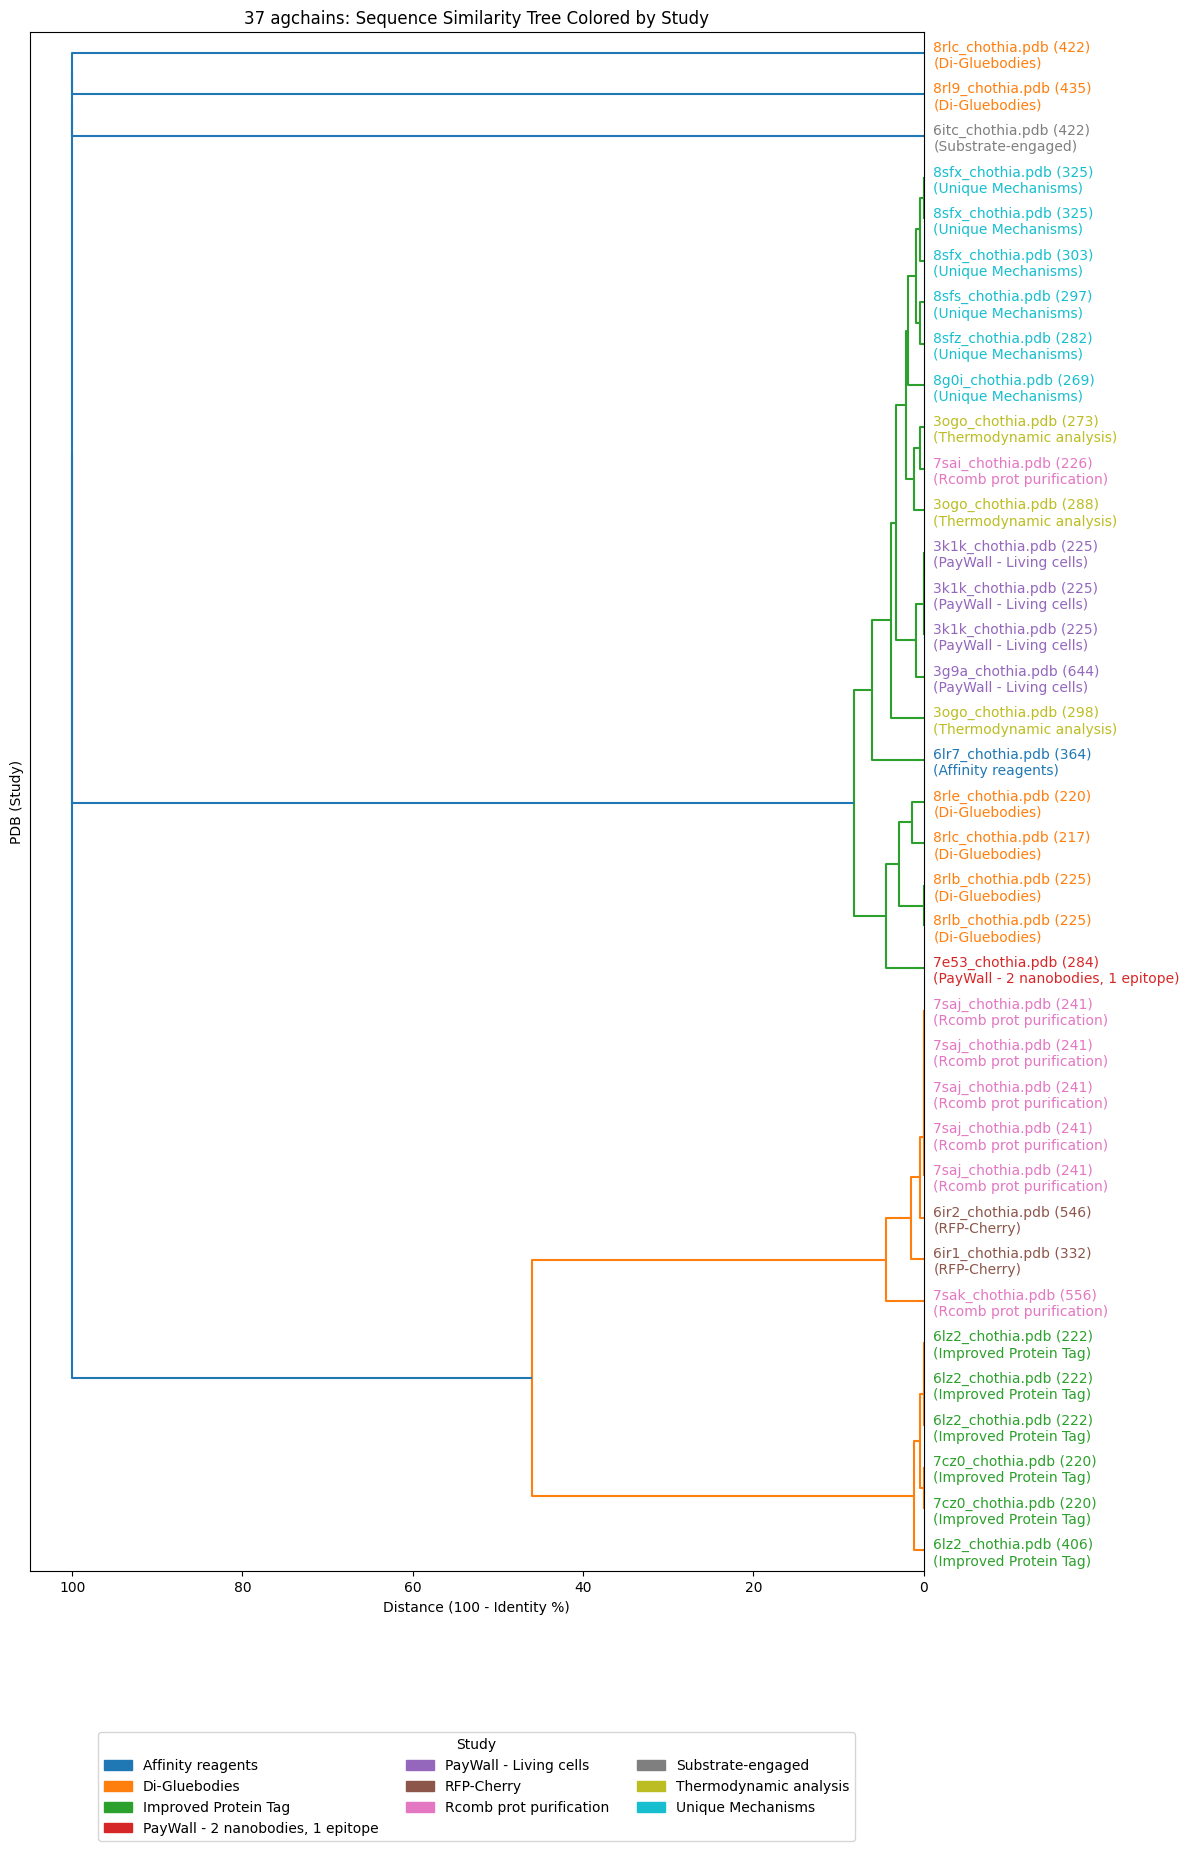

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.patches as mpatches
import numpy as np

# --- Filter Sequences ---
name_filter = 'agchain'
filtered_seqs_df = df[df['Role'].str.lower() == name_filter]
filtered_seqs = filtered_seqs_df['Sequence_noX'].tolist()

# --- Build Distance Matrix for Filtered Sequences ---
dist_matrix_filtered = pd.DataFrame(100.0, index=filtered_seqs, columns=filtered_seqs, dtype=float)

# changed to combined to include agchains that did not align above
for _, row in combined_df.iterrows():
    seq1, seq2 = row['Seq1'], row['Seq2']
    if seq1 in filtered_seqs and seq2 in filtered_seqs:
        dist = 100 - row['Identity']
        dist_matrix_filtered.loc[seq1, seq2] = dist
        dist_matrix_filtered.loc[seq2, seq1] = dist

np.fill_diagonal(dist_matrix_filtered.values, 0)

# --- Build Mappings ---
seq_to_pdb = df[['Sequence_noX', 'PDB']].set_index('Sequence_noX')['PDB'].to_dict()

# Combine sequence → PDB(Study)

seq_to_label = {}      
for seq in filtered_seqs:
    role = df[df['Sequence_noX'] == seq]['Role'].iloc[0]  # Get Role from df
    length  = role = df[df['Sequence_noX'] == seq]['Length'].iloc[0]  # Get Role from df
    if seq in seq_to_info:
        pdb, study = seq_to_info[seq]      
        #print(f"{seq}\n  → PDB: {pdb}\n  → Role: {role}\n  → Study: {study}\n")
        seq_to_label[seq] = f"{pdb} ({length})\n({study})"
    else:
        #print(f"{seq}\n  → PDB: Unknown_PDB\n  → Role: {role}\n  → Study: UnknownStudy\n")
        seq_to_label[seq] = f"Unknown_PDB ({length})\n(UnknownStudy)"


known_seqs = [seq for seq in filtered_seqs if seq_to_label.get(seq, '').find('UnknownStudy') == -1]
num_known = len(known_seqs)

# for seq in filtered_seqs:
#     pdb = seq_to_pdb.get(seq, seq)
#     study = seq_to_study.get(seq, 'Unknown')
#     seq_to_label[seq] = f"{pdb}\n({study})"

# Prepare condensed distance matrix
condensed_dist = squareform(dist_matrix_filtered.values)

# Compute linkage matrix (UPGMA)
linkage_matrix = linkage(condensed_dist, method='average')

# Plot dendrogram with combined labels
plt.figure(figsize=(12, len(filtered_seqs) * 0.5))  # Adjust height dynamically
dendro = dendrogram(linkage_matrix, labels=[seq_to_label[seq] for seq in filtered_seqs],
                    leaf_rotation=0, leaf_font_size=10, orientation='left')

# --- Color leaf labels based on Study ---
ax = plt.gca()
x_labels = ax.get_ymajorticklabels()  # y-axis for right-oriented dendrogram

for label in x_labels:
    text = label.get_text()
    # Extract study from label (between parentheses)
    study = text.split('(')[-1].replace(')', '').strip()
    label.set_color(study_to_color.get(study, 'black'))
    
# --- Legend ---
legend_handles = [mpatches.Patch(color=color, label=study) for study, color in study_to_color.items()]
plt.legend(handles=legend_handles, title='Study', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)

plt.title(f'{num_known} {name_filter}s: Sequence Similarity Tree Colored by Study')
plt.xlabel('Distance (100 - Identity %)')
plt.ylabel('PDB (Study)')
plt.tight_layout()

plt.show()

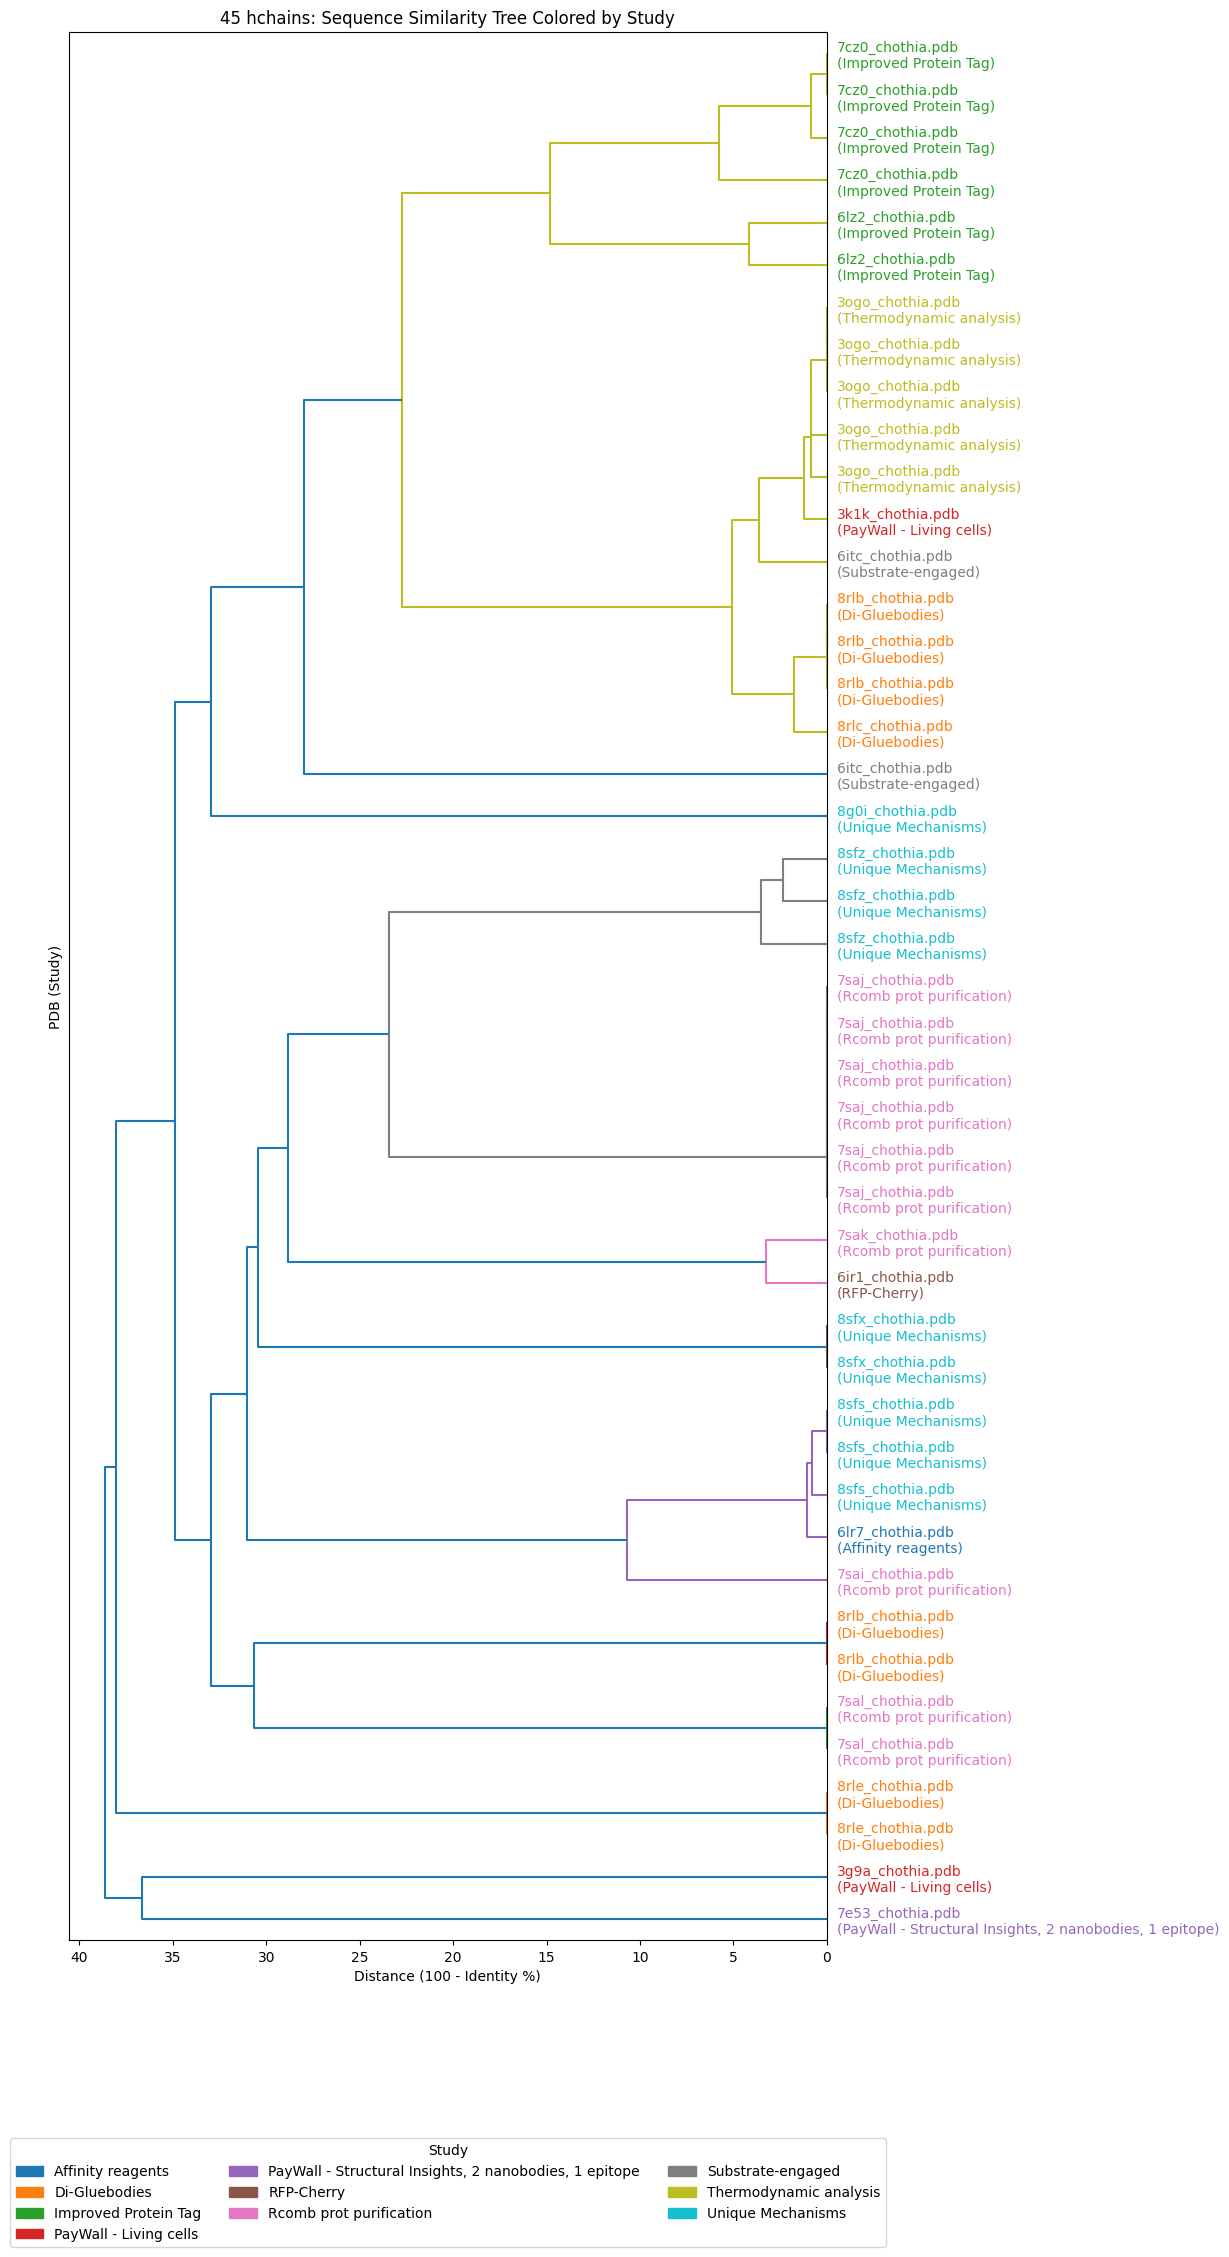

In [11]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.patches as mpatches
import numpy as np

# --- Filter Sequences ---
name_filter = 'hchain'
filtered_seqs = df[df['Role'].str.lower() == name_filter]['Sequence_noX'].tolist()

# --- Build Distance Matrix for Filtered Sequences ---
dist_matrix_filtered = pd.DataFrame(100.0, index=filtered_seqs, columns=filtered_seqs, dtype=float)

for _, row in combined_df.iterrows():
    seq1, seq2 = row['Seq1'], row['Seq2']
    if seq1 in filtered_seqs and seq2 in filtered_seqs:
        dist = 100 - row['Identity']
        dist_matrix_filtered.loc[seq1, seq2] = dist
        dist_matrix_filtered.loc[seq2, seq1] = dist

np.fill_diagonal(dist_matrix_filtered.values, 0)

# --- Build Mappings ---
seq_to_pdb = df[['Sequence_noX', 'PDB']].drop_duplicates().set_index('Sequence_noX')['PDB'].to_dict()

# Combine sequence → PDB(Study)
# seq_to_label = {seq: f"{pdb}\n({study})" for seq, (pdb, study) in seq_to_info.items() if seq in filtered_seqs}

seq_to_label = {}
for seq in filtered_seqs:
    if seq in seq_to_info:
        pdb, study = seq_to_info[seq]
        seq_to_label[seq] = f"{pdb}\n({study})"
    else:
        seq_to_label[seq] = f"Unknown_PDB\n(UnknownStudy)"
        
# for seq in filtered_seqs:
#     pdb = seq_to_pdb.get(seq, seq)
#     study = seq_to_study.get(seq, 'Unknown')
#     seq_to_label[seq] = f"{pdb}\n({study})"

# Prepare condensed distance matrix
condensed_dist = squareform(dist_matrix_filtered.values)

# Compute linkage matrix (UPGMA)
linkage_matrix = linkage(condensed_dist, method='average')

# Plot dendrogram with combined labels
plt.figure(figsize=(12, len(filtered_seqs) * 0.5))  # Adjust height dynamically
dendro = dendrogram(linkage_matrix, labels=[seq_to_label[seq] for seq in filtered_seqs],
                    leaf_rotation=0, leaf_font_size=10, orientation='left')

# --- Color leaf labels based on Study ---
ax = plt.gca()
x_labels = ax.get_ymajorticklabels()  # y-axis for right-oriented dendrogram

for label in x_labels:
    text = label.get_text()
    # Extract study from label (between parentheses)
    study = text.split('(')[-1].replace(')', '').strip()
    label.set_color(study_to_color.get(study, 'black'))
    
# --- Legend ---
legend_handles = [mpatches.Patch(color=color, label=study) for study, color in study_to_color.items()]
plt.legend(handles=legend_handles, title='Study', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)
known_seqs = [seq for seq in filtered_seqs if seq_to_label.get(seq, '').find('UnknownStudy') == -1]
num_known = len(known_seqs)

plt.title(f'{num_known} {name_filter}s: Sequence Similarity Tree Colored by Study')
plt.xlabel('Distance (100 - Identity %)')
plt.ylabel('PDB (Study)')
plt.tight_layout()
plt.show()


### Vertical -- Can drop move to end

In [ ]:
import matplotlib.colors as mcolors

# Create mapping: sequence → Study
seq_to_study = pd.concat([
    similar_df[['Seq1', 'Study_Seq1', 'PDB_Seq1']].rename(columns={'Seq1': 'Seq', 'Study_Seq1': 'Study', 'PDB_Seq1': 'PDB'}),
    similar_df[['Seq2', 'Study_Seq2', 'PDB_Seq2']].rename(columns={'Seq2': 'Seq', 'Study_Seq2': 'Study', 'PDB_Seq2': 'PDB'})
]).drop_duplicates().set_index('Seq')['Study'].to_dict()

# Unique studies & colors
unique_studies = sorted(set(seq_to_study.values()))
color_palette = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())

# Map Study to color
study_to_color = {study: color_palette[i % len(color_palette)] for i, study in enumerate(unique_studies)}
study_to_color

{'Affinity reagents': '#1f77b4',
 'Di-Gluebodies': '#ff7f0e',
 'Improved Protein Tag': '#2ca02c',
 'PayWall - 2 nanobodies, 1 epitope': '#d62728',
 'PayWall - Living cells': '#9467bd',
 'RFP-Cherry': '#8c564b',
 'Rcomb prot purification': '#e377c2',
 'Substrate-engaged': '#7f7f7f',
 'Thermodynamic analysis': '#bcbd22',
 'Unique Mechanisms': '#17becf'}

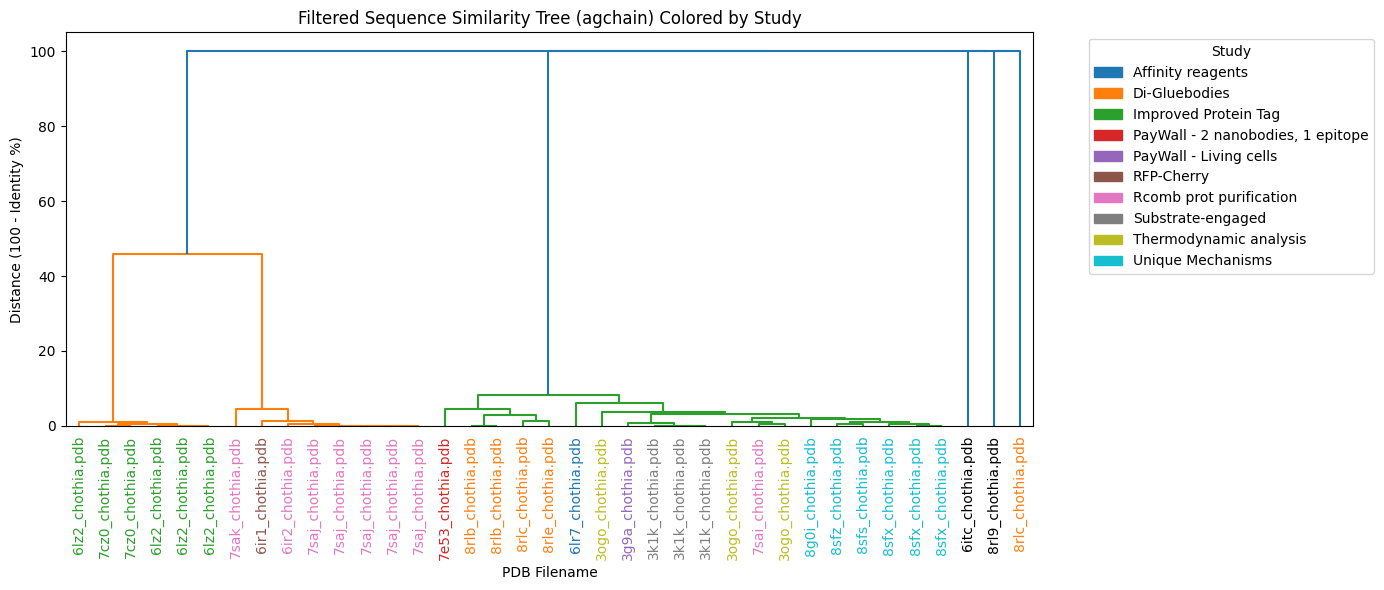

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.patches as mpatches
import numpy as np

# Filter seqs

name_filter = 'agchain'

filtered_seqs = df[df['Role'].str.lower() == name_filter ]['Sequence_noX'].tolist()
# print (hchain_seqs)
# Filter all sequences to only those containing 'hchain' or 'agchain' (case-insensitive)
# filtered_seqs = [seq for seq in all_seqs if ('hchain' in seq.lower())]
# print(filtered_seqs)
# Initialize matrix for filtered sequences only

dist_matrix_filtered = pd.DataFrame(100.0, index=filtered_seqs, columns=filtered_seqs, dtype=float)

# Fill distances from similar_df but only if both sequences are in filtered_seqs
for _, row in similar_df.iterrows():
    seq1, seq2 = row['Seq1'], row['Seq2']
    if seq1 in filtered_seqs and seq2 in filtered_seqs:
        dist = 100 - row['Identity']
        dist_matrix_filtered.loc[seq1, seq2] = dist
        dist_matrix_filtered.loc[seq2, seq1] = dist

# Zero distance on diagonal
np.fill_diagonal(dist_matrix_filtered.values, 0)

# --- Filter sequences to only hchain and agchain ---
# filtered_seqs = [seq for seq in all_seqs if ('hchain' in seq.lower())]

# Filter the distance matrix to include only filtered sequences
# filtered_dist_matrix = dist_matrix.loc[filtered_seqs, filtered_seqs]

# Build a mapping from sequence to PDB (or filename)
seq_to_pdb = df[['Sequence_noX', 'PDB']].drop_duplicates().set_index('Sequence_noX')['PDB'].to_dict()

# Prepare condensed distance matrix from filtered distance matrix
condensed_dist = squareform(dist_matrix_filtered.values)

# Compute linkage matrix (UPGMA clustering)
linkage_matrix = linkage(condensed_dist, method='average')

# Plot dendrogram with colored labels by Study for filtered sequences
# Replace sequence labels with their PDB names
pdb_labels = [seq_to_pdb.get(seq, seq) for seq in filtered_seqs]

# Plot dendrogram with PDB labels
plt.figure(figsize=(14, 6))
dendro = dendrogram(linkage_matrix, labels=pdb_labels, leaf_rotation=90, leaf_font_size=10)

# Color leaf labels based on Study mapping
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for label in x_labels:
    pdb_name = label.get_text()
    
    # Get corresponding sequence for this PDB (reverse lookup)
    # Since seq_to_pdb is seq → pdb, we need pdb → seq lookup
    seq = next((s for s, p in seq_to_pdb.items() if p == pdb_name), None)
    
    study = seq_to_study.get(seq, 'Unknown')
    label.set_color(study_to_color.get(study, 'black'))

# Add legend for Study colors
legend_handles = [mpatches.Patch(color=color, label=study) for study, color in study_to_color.items()]
plt.legend(handles=legend_handles, title='Study', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Filtered Sequence Similarity Tree (' + name_filter +') Colored by Study')
plt.xlabel('PDB Filename')
plt.ylabel('Distance (100 - Identity %)')
plt.tight_layout()
plt.show()

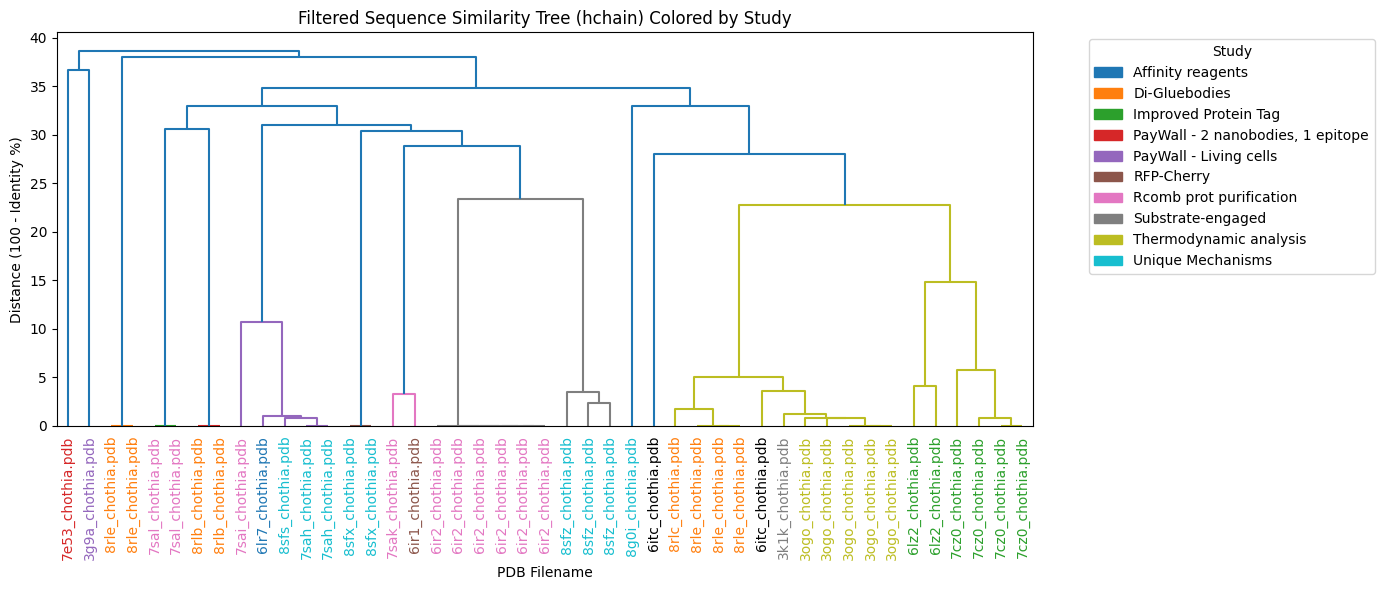

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.patches as mpatches

# Filter seqs

name_filter = 'hchain'

filtered_seqs = df[df['Role'].str.lower() == name_filter ]['Sequence_noX'].tolist()
# print (hchain_seqs)
# Filter all sequences to only those containing 'hchain' or 'agchain' (case-insensitive)
# filtered_seqs = [seq for seq in all_seqs if ('hchain' in seq.lower())]
# print(filtered_seqs)
# Initialize matrix for filtered sequences only

dist_matrix_filtered = pd.DataFrame(100.0, index=filtered_seqs, columns=filtered_seqs, dtype=float)

# Fill distances from similar_df but only if both sequences are in filtered_seqs
for _, row in similar_df.iterrows():
    seq1, seq2 = row['Seq1'], row['Seq2']
    if seq1 in filtered_seqs and seq2 in filtered_seqs:
        dist = 100 - row['Identity']
        dist_matrix_filtered.loc[seq1, seq2] = dist
        dist_matrix_filtered.loc[seq2, seq1] = dist

# Zero distance on diagonal
np.fill_diagonal(dist_matrix_filtered.values, 0)

# --- Filter sequences to only hchain and agchain ---
# filtered_seqs = [seq for seq in all_seqs if ('hchain' in seq.lower())]

# Filter the distance matrix to include only filtered sequences
# filtered_dist_matrix = dist_matrix.loc[filtered_seqs, filtered_seqs]

# Build a mapping from sequence to PDB (or filename)
seq_to_pdb = df[['Sequence_noX', 'PDB']].drop_duplicates().set_index('Sequence_noX')['PDB'].to_dict()

# Prepare condensed distance matrix from filtered distance matrix
condensed_dist = squareform(dist_matrix_filtered.values)

# Compute linkage matrix (UPGMA clustering)
linkage_matrix = linkage(condensed_dist, method='average')

# Plot dendrogram with colored labels by Study for filtered sequences
# Replace sequence labels with their PDB names
pdb_labels = [seq_to_pdb.get(seq, seq) for seq in filtered_seqs]

# Plot dendrogram with PDB labels
plt.figure(figsize=(14, 6))
dendro = dendrogram(linkage_matrix, labels=pdb_labels, leaf_rotation=90, leaf_font_size=10)

# Color leaf labels based on Study mapping
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for label in x_labels:
    pdb_name = label.get_text()
    
    # Get corresponding sequence for this PDB (reverse lookup)
    # Since seq_to_pdb is seq → pdb, we need pdb → seq lookup
    seq = next((s for s, p in seq_to_pdb.items() if p == pdb_name), None)
    
    study = seq_to_study.get(seq, 'Unknown')
    label.set_color(study_to_color.get(study, 'black'))

# Add legend for Study colors
legend_handles = [mpatches.Patch(color=color, label=study) for study, color in study_to_color.items()]
plt.legend(handles=legend_handles, title='Study', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Filtered Sequence Similarity Tree (' + name_filter +') Colored by Study')
plt.xlabel('PDB Filename')
plt.ylabel('Distance (100 - Identity %)')
plt.tight_layout()
plt.show()